<a href="https://colab.research.google.com/github/Andger1975/ml_python/blob/master/NLP_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip3 install pillow

In [3]:
!pip3 install scipy==1.1.0

     |████████████████████████████████| 31.2MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.2
    Uninstalling scipy-1.3.2:
      Successfully uninstalled scipy-1.3.2


### Data preprocessing

In [4]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("../content/drive/My Drive/data/image_codes.npy")
captions = json.load(open('../content/drive/My Drive/data/captions_tokenized.json'))

CPU times: user 224 ms, sys: 853 ms, total: 1.08 s
Wall time: 15.8 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [6]:
len(captions)

118287

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [8]:
print(len(captions))
print(captions[0])

118287
[['#START#', 'people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.', '#END#'], ['#START#', 'an', 'open', 'market', 'full', 'of', 'people', 'and', 'piles', 'of', 'vegetables', '.', '#END#'], ['#START#', 'people', 'are', 'shopping', 'at', 'an', 'open', 'air', 'produce', 'market', '.', '#END#'], ['#START#', 'large', 'piles', 'of', 'carrots', 'and', 'potatoes', 'at', 'a', 'crowded', 'outdoor', 'market', '.', '#END#'], ['#START#', 'people', 'shop', 'for', 'vegetables', 'like', 'carrots', 'and', 'potatoes', 'at', 'an', 'open', 'air', 'market', '.', '#END#']]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [9]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        for item in sentence:
            word_counts[item] += 1
            
print(len(word_counts))
print(word_counts)

29416
Counter({'a': 978125, '#START#': 591435, '#END#': 591435, '.': 444651, 'on': 215537, 'of': 203940, 'the': 197668, 'in': 183933, 'with': 154705, 'and': 140709, 'is': 98138, 'man': 72984, 'to': 68106, 'sitting': 52880, 'an': 49848, 'two': 48320, ',': 44448, 'at': 42703, 'standing': 42450, 'people': 41895, 'are': 41060, 'next': 37196, 'white': 36171, 'woman': 33934, 'street': 30253, 'table': 30157, 'holding': 27952, 'that': 27920, 'large': 24540, 'it': 24528, 'person': 24402, 'some': 24314, 'down': 23093, 'top': 22262, 'group': 21585, 'up': 20964, 'field': 20768, 'small': 20074, 'tennis': 19577, 'near': 19558, 'front': 19501, 'his': 19475, 'black': 19336, 'train': 18600, 'plate': 18366, 'room': 18299, 'dog': 18109, 'riding': 18081, 'red': 17350, 'cat': 17110, 'young': 17107, 'by': 17017, 'water': 16425, 'baseball': 15691, 'has': 15107, 'while': 14699, 'playing': 14666, 'walking': 14561, 'bathroom': 14427, 'sign': 14035, 'blue': 13752, 'kitchen': 13386, 'food': 13236, 'grass': 13007,

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[0])

#0 - UNK, 1 - START, 2- END, 3 - PAD (spacer)

array([[ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  2,  3,  3,  3,  3,  3],
       [ 1,  7,  8,  9, 13, 14,  4, 15, 16, 14, 11, 12,  2,  3,  3,  3],
       [ 1,  4, 17,  5, 18,  7,  8, 19, 20,  9, 12,  2,  3,  3,  3,  3],
       [ 1, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26,  9, 12,  2,  3,  3],
       [ 1,  4, 27, 10, 11, 28, 22, 15, 23, 18,  7,  8, 19,  9, 12,  2]],
      dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        #
        # vocabr_size - количество слов в поезде, вале и тестовом наборе
        # vector_size - измерение используемых векторов слов
        # https://stackoverflow.com/questions/50747947/embedding-in-pytorch
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size) # 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        # self.lstm = <YOUR CODE>
        # input_size is the number of features of the input vector x
        # hidden_size is the number of units of your LSTM cell. This means all the layers (input, forget, etc.) will have this size. 
        # https://www.reddit.com/r/deeplearning/comments/9lhnuh/questions_about_lstm_and_pytorch/
        # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)
        # if your input is batch first then the output will also be batch first.

        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units,  batch_first = True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        # elf.logits = <YOUR CODE>
        # predictions that a classification model generates, which is ordinarily then passed to a normalization function
        # The raw predictions which come out of the last layer of the neural network.
        self.logits = nn.Linear(lstm_units, n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        # captions_emb = <YOUR CODE>
        # nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring (captions_emb)
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        
        
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # lstm_out = <YOUR CODE>
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        # logits = <YOUR CODE>
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)

In [16]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS (end of sentence...) do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    # view function is meant to reshape the tensor
    # we don't know how many rows we want but are sure of the number of columns
    reshaped_caps = captions_ix_next.view(-1)
    mask = (reshaped_caps != pad_ix).type(torch.float)
    
    # multiplying elementwise loss by (captions_ix_next != pad_ix)
    # Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1
    loss = F.cross_entropy(logits_for_next.view(-1, logits_for_next.shape[-1]),
                           captions_ix_next.view(-1), reduction = 'none') * mask
    
    # loss = <YOUR CODE>
    loss = loss.sum() / mask.sum()
    return loss.reshape(-1)

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
#<YOUR CODE>

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32, device=device), torch.tensor(batch_captions_ix, dtype=torch.int64, device=device)
    

In [22]:
generate_batch(img_codes,captions,3)

(tensor([[1.0171, 0.1176, 0.1462,  ..., 0.6404, 0.6824, 0.0746],
         [0.7837, 0.3652, 0.0629,  ..., 0.0085, 0.3212, 0.0814],
         [0.1853, 0.1240, 0.6583,  ..., 0.1069, 0.7569, 0.1919]],
        device='cuda:0'),
 tensor([[   1,   24, 4891,  269,   94,    6,  159,   14, 1464, 2661,   12,    2],
         [   1,   24,   54,   15,  404, 2362,   99,   18,   24, 1359,   12,    2],
         [   1,   24,  122,  867,   63,  136,    0, 2120,   35,   45, 1328,    2]],
        device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
network = CaptionNet(n_tokens).to(device)
opt = torch.optim.Adam(network.parameters())
batch_size = 60  # adjust me
n_epochs = 110  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 25  # how many batches are used for validation after each epoch

In [24]:
from tqdm import tqdm, trange

for epoch in trange(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # <YOUR CODE>
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

 11%|█         | 11/100 [00:00<00:00, 101.61it/s]


Epoch: 0, train loss: 5.349613003730774, val loss: 4.553879146575928



 10%|█         | 10/100 [00:00<00:00, 92.74it/s]


Epoch: 1, train loss: 4.331007843017578, val loss: 4.167592792510987



 10%|█         | 10/100 [00:00<00:00, 92.66it/s]


Epoch: 2, train loss: 4.0446764183044435, val loss: 3.9173222637176512



 10%|█         | 10/100 [00:00<00:00, 97.74it/s]


Epoch: 3, train loss: 3.823518178462982, val loss: 3.7398769664764404



 10%|█         | 10/100 [00:00<00:00, 93.78it/s]


Epoch: 4, train loss: 3.6711484599113464, val loss: 3.6438817405700683



 10%|█         | 10/100 [00:00<00:00, 96.65it/s]


Epoch: 5, train loss: 3.55061176776886, val loss: 3.5347828006744386



 10%|█         | 10/100 [00:00<00:00, 92.08it/s]


Epoch: 6, train loss: 3.410765404701233, val loss: 3.3801392936706542



 10%|█         | 10/100 [00:00<00:00, 93.33it/s]


Epoch: 7, train loss: 3.3173086619377137, val loss: 3.3058279037475584



 10%|█         | 10/100 [00:00<00:00, 96.86it/s]


Epoch: 8, train loss: 3.2523170495033265, val loss: 3.244528169631958



 10%|█         | 10/100 [00:00<00:00, 92.21it/s]


Epoch: 9, train loss: 3.1811037993431093, val loss: 3.1450672245025633



 10%|█         | 10/100 [00:00<00:00, 91.35it/s]


Epoch: 10, train loss: 3.136468002796173, val loss: 3.15606463432312



 10%|█         | 10/100 [00:00<00:00, 92.62it/s]


Epoch: 11, train loss: 3.099389307498932, val loss: 3.0124552822113038



 10%|█         | 10/100 [00:00<00:00, 90.10it/s]


Epoch: 12, train loss: 3.0460622358322142, val loss: 3.050774335861206



 10%|█         | 10/100 [00:00<00:00, 95.96it/s]


Epoch: 13, train loss: 3.0629053354263305, val loss: 3.017235803604126



 10%|█         | 10/100 [00:00<00:00, 97.06it/s]


Epoch: 14, train loss: 3.01959552526474, val loss: 2.9789012336730956



  9%|▉         | 9/100 [00:00<00:01, 89.04it/s]


Epoch: 15, train loss: 2.958915202617645, val loss: 2.97289493560791



  9%|▉         | 9/100 [00:00<00:01, 84.71it/s]


Epoch: 16, train loss: 2.9364340329170227, val loss: 2.905759515762329



  9%|▉         | 9/100 [00:00<00:01, 89.37it/s]


Epoch: 17, train loss: 2.918015024662018, val loss: 2.9518321800231933



 10%|█         | 10/100 [00:00<00:00, 92.38it/s]


Epoch: 18, train loss: 2.892584924697876, val loss: 2.9155126571655274



 10%|█         | 10/100 [00:00<00:00, 91.57it/s]


Epoch: 19, train loss: 2.893505516052246, val loss: 2.8799922561645506



  9%|▉         | 9/100 [00:00<00:01, 87.22it/s]


Epoch: 20, train loss: 2.8494572329521177, val loss: 2.875523023605347



 11%|█         | 11/100 [00:00<00:00, 104.19it/s]


Epoch: 21, train loss: 2.878278520107269, val loss: 2.8601255416870117



  9%|▉         | 9/100 [00:00<00:01, 89.77it/s]


Epoch: 22, train loss: 2.8565706777572633, val loss: 2.867051591873169



  9%|▉         | 9/100 [00:00<00:01, 89.89it/s]


Epoch: 23, train loss: 2.8250809574127196, val loss: 2.8852780151367186



  9%|▉         | 9/100 [00:00<00:01, 84.10it/s]


Epoch: 24, train loss: 2.8218113732337953, val loss: 2.81358473777771



 10%|█         | 10/100 [00:00<00:01, 89.12it/s]


Epoch: 25, train loss: 2.789053122997284, val loss: 2.806452331542969



 10%|█         | 10/100 [00:00<00:00, 92.33it/s]


Epoch: 26, train loss: 2.7824363803863523, val loss: 2.8278371620178224



 10%|█         | 10/100 [00:00<00:00, 92.56it/s]


Epoch: 27, train loss: 2.754931471347809, val loss: 2.817442388534546



 10%|█         | 10/100 [00:00<00:01, 89.22it/s]


Epoch: 28, train loss: 2.7530487394332885, val loss: 2.8314805030822754



  9%|▉         | 9/100 [00:00<00:01, 82.58it/s]


Epoch: 29, train loss: 2.7529712748527526, val loss: 2.8253706645965577



 10%|█         | 10/100 [00:00<00:00, 98.90it/s]


Epoch: 30, train loss: 2.75710414648056, val loss: 2.724548692703247



  9%|▉         | 9/100 [00:00<00:01, 83.02it/s]


Epoch: 31, train loss: 2.7142694330215456, val loss: 2.7452570819854736



 10%|█         | 10/100 [00:00<00:00, 94.78it/s]


Epoch: 32, train loss: 2.712342927455902, val loss: 2.7953776359558105



 10%|█         | 10/100 [00:00<00:00, 94.91it/s]


Epoch: 33, train loss: 2.7235130167007444, val loss: 2.735823450088501



 10%|█         | 10/100 [00:00<00:00, 94.34it/s]


Epoch: 34, train loss: 2.693688552379608, val loss: 2.71398717880249



  9%|▉         | 9/100 [00:00<00:01, 84.91it/s]


Epoch: 35, train loss: 2.6739221143722536, val loss: 2.733427734375



 10%|█         | 10/100 [00:00<00:00, 92.00it/s]


Epoch: 36, train loss: 2.6833352708816527, val loss: 2.6961801624298096



 10%|█         | 10/100 [00:00<00:00, 93.41it/s]


Epoch: 37, train loss: 2.695345981121063, val loss: 2.7100466537475585



  9%|▉         | 9/100 [00:00<00:01, 85.91it/s]


Epoch: 38, train loss: 2.6615555930137633, val loss: 2.702785654067993



 10%|█         | 10/100 [00:00<00:00, 98.67it/s]


Epoch: 39, train loss: 2.675463709831238, val loss: 2.712778491973877



 10%|█         | 10/100 [00:00<00:00, 90.69it/s]


Epoch: 40, train loss: 2.6401816606521606, val loss: 2.6534685039520265



  9%|▉         | 9/100 [00:00<00:01, 87.49it/s]


Epoch: 41, train loss: 2.655107753276825, val loss: 2.641761178970337



  9%|▉         | 9/100 [00:00<00:01, 86.46it/s]


Epoch: 42, train loss: 2.6507165002822877, val loss: 2.6777845573425294



 10%|█         | 10/100 [00:00<00:00, 92.54it/s]


Epoch: 43, train loss: 2.625382218360901, val loss: 2.670872869491577



  9%|▉         | 9/100 [00:00<00:01, 86.23it/s]


Epoch: 44, train loss: 2.627614417076111, val loss: 2.675033655166626



 10%|█         | 10/100 [00:00<00:00, 91.79it/s]


Epoch: 45, train loss: 2.6510866522789, val loss: 2.7047945404052736



 10%|█         | 10/100 [00:00<00:00, 91.31it/s]


Epoch: 46, train loss: 2.623791525363922, val loss: 2.6747701835632323



 10%|█         | 10/100 [00:00<00:00, 95.69it/s]


Epoch: 47, train loss: 2.606663293838501, val loss: 2.6576034450531005



  9%|▉         | 9/100 [00:00<00:01, 88.02it/s]


Epoch: 48, train loss: 2.5945180749893186, val loss: 2.6654888248443602



 11%|█         | 11/100 [00:00<00:00, 104.47it/s]


Epoch: 49, train loss: 2.5922071599960326, val loss: 2.6145962142944335



 10%|█         | 10/100 [00:00<00:00, 98.52it/s]


Epoch: 50, train loss: 2.578208210468292, val loss: 2.628195171356201



 10%|█         | 10/100 [00:00<00:00, 91.22it/s]


Epoch: 51, train loss: 2.5891129970550537, val loss: 2.6055970573425293



 10%|█         | 10/100 [00:00<00:01, 89.54it/s]


Epoch: 52, train loss: 2.579924099445343, val loss: 2.6484810447692873



  9%|▉         | 9/100 [00:00<00:01, 80.32it/s]


Epoch: 53, train loss: 2.5745271396636964, val loss: 2.648773431777954



 10%|█         | 10/100 [00:00<00:00, 97.15it/s]


Epoch: 54, train loss: 2.5861430883407595, val loss: 2.6317017555236815



 10%|█         | 10/100 [00:00<00:00, 98.20it/s]


Epoch: 55, train loss: 2.5445141911506655, val loss: 2.585615634918213



 10%|█         | 10/100 [00:00<00:00, 99.64it/s]


Epoch: 56, train loss: 2.5682204747200013, val loss: 2.607423810958862



 10%|█         | 10/100 [00:00<00:00, 91.37it/s]


Epoch: 57, train loss: 2.556083950996399, val loss: 2.598555030822754



 10%|█         | 10/100 [00:00<00:00, 94.85it/s]


Epoch: 58, train loss: 2.569906756877899, val loss: 2.587691249847412



 10%|█         | 10/100 [00:00<00:00, 99.37it/s]


Epoch: 59, train loss: 2.553471977710724, val loss: 2.6293821907043458



 10%|█         | 10/100 [00:00<00:00, 98.86it/s]


Epoch: 60, train loss: 2.5421223306655882, val loss: 2.6320345115661623



 10%|█         | 10/100 [00:00<00:00, 96.93it/s]


Epoch: 61, train loss: 2.540973994731903, val loss: 2.5640605545043944



  9%|▉         | 9/100 [00:00<00:01, 86.11it/s]


Epoch: 62, train loss: 2.5324056792259215, val loss: 2.627056531906128



 10%|█         | 10/100 [00:00<00:00, 94.21it/s]


Epoch: 63, train loss: 2.543048825263977, val loss: 2.6255197429656985



 10%|█         | 10/100 [00:00<00:00, 95.79it/s]


Epoch: 64, train loss: 2.5320834016799925, val loss: 2.6076541900634767



 10%|█         | 10/100 [00:00<00:00, 90.87it/s]


Epoch: 65, train loss: 2.5428960013389585, val loss: 2.6061003017425537



  9%|▉         | 9/100 [00:00<00:01, 87.34it/s]


Epoch: 66, train loss: 2.510943992137909, val loss: 2.584745292663574



  8%|▊         | 8/100 [00:00<00:01, 79.79it/s]


Epoch: 67, train loss: 2.500607285499573, val loss: 2.582707824707031



  9%|▉         | 9/100 [00:00<00:01, 88.68it/s]


Epoch: 68, train loss: 2.5363910794258118, val loss: 2.621481761932373



 10%|█         | 10/100 [00:00<00:00, 94.26it/s]


Epoch: 69, train loss: 2.5408490562438963, val loss: 2.5966938495635987



  9%|▉         | 9/100 [00:00<00:01, 84.82it/s]


Epoch: 70, train loss: 2.5360485315322876, val loss: 2.6377048015594484



 10%|█         | 10/100 [00:00<00:00, 99.43it/s]


Epoch: 71, train loss: 2.507446377277374, val loss: 2.577573480606079



 10%|█         | 10/100 [00:00<00:00, 93.02it/s]


Epoch: 72, train loss: 2.4929483771324157, val loss: 2.578934364318848



  9%|▉         | 9/100 [00:00<00:01, 84.08it/s]


Epoch: 73, train loss: 2.501510500907898, val loss: 2.5455055141448977



 10%|█         | 10/100 [00:00<00:00, 97.25it/s]


Epoch: 74, train loss: 2.508473539352417, val loss: 2.5273460960388183



 10%|█         | 10/100 [00:00<00:00, 95.41it/s]


Epoch: 75, train loss: 2.474731957912445, val loss: 2.5373015213012695



 10%|█         | 10/100 [00:00<00:00, 96.18it/s]


Epoch: 76, train loss: 2.4907386183738707, val loss: 2.549036455154419



  9%|▉         | 9/100 [00:00<00:01, 86.40it/s]


Epoch: 77, train loss: 2.4912218284606933, val loss: 2.548109073638916



 10%|█         | 10/100 [00:00<00:00, 90.01it/s]


Epoch: 78, train loss: 2.4886796617507936, val loss: 2.590467834472656



 10%|█         | 10/100 [00:00<00:00, 96.51it/s]


Epoch: 79, train loss: 2.5141783857345583, val loss: 2.5318167114257815



 10%|█         | 10/100 [00:00<00:00, 93.73it/s]


Epoch: 80, train loss: 2.483744115829468, val loss: 2.5607224178314207



 10%|█         | 10/100 [00:00<00:00, 91.22it/s]


Epoch: 81, train loss: 2.4672968769073487, val loss: 2.5904642581939696



 10%|█         | 10/100 [00:00<00:00, 91.63it/s]


Epoch: 82, train loss: 2.464352807998657, val loss: 2.5571809577941895



 10%|█         | 10/100 [00:00<00:00, 97.97it/s]


Epoch: 83, train loss: 2.4873726916313172, val loss: 2.5953323459625244



 10%|█         | 10/100 [00:00<00:00, 92.90it/s]


Epoch: 84, train loss: 2.4842106175422667, val loss: 2.555574502944946



  9%|▉         | 9/100 [00:00<00:01, 80.59it/s]


Epoch: 85, train loss: 2.4710365557670593, val loss: 2.5977691173553468



 10%|█         | 10/100 [00:00<00:00, 93.06it/s]


Epoch: 86, train loss: 2.4896938157081605, val loss: 2.5384616088867187



 10%|█         | 10/100 [00:00<00:00, 91.55it/s]


Epoch: 87, train loss: 2.4633513832092286, val loss: 2.540288667678833



 10%|█         | 10/100 [00:00<00:00, 91.16it/s]


Epoch: 88, train loss: 2.4512516713142394, val loss: 2.5503952503204346



 10%|█         | 10/100 [00:00<00:00, 92.39it/s]


Epoch: 89, train loss: 2.4512850785255433, val loss: 2.5088874435424806



  9%|▉         | 9/100 [00:00<00:01, 82.57it/s]


Epoch: 90, train loss: 2.449160330295563, val loss: 2.569462547302246



  9%|▉         | 9/100 [00:00<00:01, 87.83it/s]


Epoch: 91, train loss: 2.4515881276130678, val loss: 2.5323573303222657



  9%|▉         | 9/100 [00:00<00:01, 88.90it/s]


Epoch: 92, train loss: 2.4551369881629945, val loss: 2.543116321563721



 10%|█         | 10/100 [00:00<00:00, 94.10it/s]


Epoch: 93, train loss: 2.44243531703949, val loss: 2.5590559005737306



 10%|█         | 10/100 [00:00<00:00, 91.02it/s]


Epoch: 94, train loss: 2.450523998737335, val loss: 2.542765302658081



 10%|█         | 10/100 [00:00<00:00, 95.06it/s]


Epoch: 95, train loss: 2.463778882026672, val loss: 2.524087495803833



 10%|█         | 10/100 [00:00<00:00, 92.07it/s]


Epoch: 96, train loss: 2.457985830307007, val loss: 2.4695612716674806



 10%|█         | 10/100 [00:00<00:00, 94.13it/s]


Epoch: 97, train loss: 2.4176800084114074, val loss: 2.513737373352051



 10%|█         | 10/100 [00:00<00:00, 97.57it/s]


Epoch: 98, train loss: 2.4309811210632324, val loss: 2.5650937080383303



 10%|█         | 10/100 [00:00<00:00, 94.45it/s]


Epoch: 99, train loss: 2.4351369643211367, val loss: 2.5300611209869386



 10%|█         | 10/100 [00:00<00:00, 90.82it/s]


Epoch: 100, train loss: 2.4353097558021544, val loss: 2.535642747879028



 10%|█         | 10/100 [00:00<00:00, 96.04it/s]


Epoch: 101, train loss: 2.4230266928672792, val loss: 2.5029913234710692



  9%|▉         | 9/100 [00:00<00:01, 88.84it/s]


Epoch: 102, train loss: 2.4453376150131225, val loss: 2.519225206375122



 10%|█         | 10/100 [00:00<00:00, 96.83it/s]


Epoch: 103, train loss: 2.4474827814102174, val loss: 2.5291405010223387



 10%|█         | 10/100 [00:00<00:01, 89.46it/s]


Epoch: 104, train loss: 2.4306864500045777, val loss: 2.4842681312561035



 10%|█         | 10/100 [00:00<00:00, 91.36it/s]


Epoch: 105, train loss: 2.4195975971221926, val loss: 2.464235210418701



 10%|█         | 10/100 [00:00<00:00, 97.57it/s]


Epoch: 106, train loss: 2.4051474595069884, val loss: 2.4881962966918945



  9%|▉         | 9/100 [00:00<00:01, 87.48it/s]


Epoch: 107, train loss: 2.411221079826355, val loss: 2.515443134307861



  9%|▉         | 9/100 [00:00<00:01, 89.32it/s]


Epoch: 108, train loss: 2.405458073616028, val loss: 2.511228437423706



100%|██████████| 110/110 [02:13<00:00,  1.22s/it]


Epoch: 109, train loss: 2.4235512232780456, val loss: 2.531105899810791
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [25]:
!wget https://raw.githubusercontent.com/swish-ds/Practical_DL/spring2019/homework04/beheaded_inception3.py -O beheaded_inception3.py

--2019-11-20 04:01:00--  https://raw.githubusercontent.com/swish-ds/Practical_DL/spring2019/homework04/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1776 (1.7K) [text/plain]
Saving to: ‘beheaded_inception3.py’

beheaded_inception3 100%[===================>]   1.73K  --.-KB/s    in 0s      

2019-11-20 04:01:00 (323 MB/s) - ‘beheaded_inception3.py’ saved [1776/1776]



In [26]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 47.1MB/s] 


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
            next_word_logits = network.forward(vectors_neck.to(device), prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [0]:
#pip install scipy==1.1.0 --user

In [28]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-11-20 04:01:31--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.52.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.52.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K  --.-KB/s    in 0.02s   

2019-11-20 04:01:31 (4.76 MB/s) - ‘img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


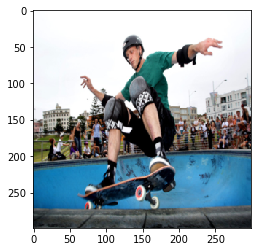

In [29]:
plt.imshow(img)

In [30]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5)[1:-1]))

a man riding a skateboard down a ramp .
a skateboarder is doing a trick in the air .
a skateboarder doing a trick on a skate board .
a skateboarder is doing a trick on a ramp .
a skateboarder doing a trick on a ramp .
a skateboarder is riding on a skate board .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick on a ramp .
a skateboarder is riding his board on the street .
a skateboarder is doing a trick in the air .


--2019-11-20 04:01:57--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.02s   

2019-11-20 04:01:58 (4.93 MB/s) - ‘cat.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


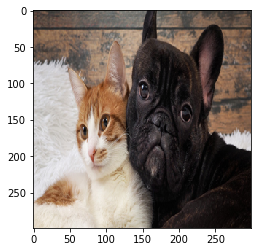

a dog is laying on the floor next to a black cat .
a cat sitting on a couch with a laptop on it .
a dog is laying on a couch with a cat on it .
a dog is laying on a bed with a blanket .
a dog is sleeping on a couch in a room .
a dog laying on a bed with a blanket .
a dog laying on a bed with a cat on it .
a dog is laying on the floor next to a cat .
a dog is sleeping on a couch with a cat on it .
a dog is laying on a couch with a cat on it .


In [31]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O cat.jpg
img = plt.imread('cat.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

20160116_180112.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


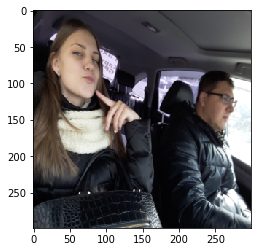

a man sitting on a bench with a dog .
a man sitting on a couch with a dog .
a man and a woman sitting on a bench .
a man sitting on a couch with a dog .
a man sitting on a couch with a dog .
a man sitting on a couch with a dog and a dog .
a man sitting on a couch with a dog .
a man sitting on a couch with a dog .
a man sitting on a couch with a dog .
a man and woman sitting on a bench in a car .
20160305_171458.jpg


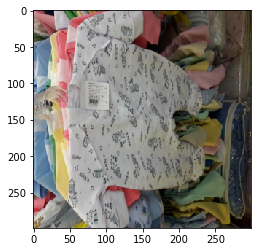

a close up of a person holding a hot dog
a cake with a knife and a cup of coffee .
a hot dog with a pair of scissors .
a stuffed animal with a pair of scissors .
a dog is laying on a bed .
a cake with a knife and a cup of coffee .
a close up of a person holding a hot dog
a hot dog with a hot dog on a bun .
a cake with a knife and a cup of coffee .
a cake with a knife and a knife .
20160305_175157.jpg


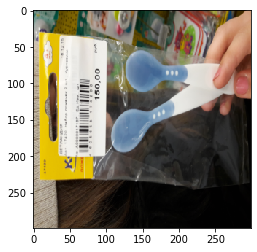

a pair of scissors and a cup of coffee .
a close up of a tooth brush and a cup of coffee .
a toothbrush and a cup of coffee are on a table .
a toothbrush and a cup of coffee are on a table .
a close up of a tooth brush and a cup of coffee
a close up of a tooth brush and a cup of coffee
a close up of a tooth brush and a cup of coffee .
a close up of a tooth brush and a cup of coffee
a close up of a tooth brush and a cup of coffee
a close up of a tooth brush
20160306_143227.jpg


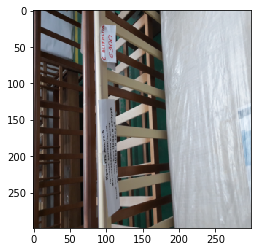

a clock is sitting on a pole next to a building .
a clock is shown on a pole .
a clock on a corner of a building .
a sign that is in the middle of a building .
a clock is shown on the side of a building .
a clock is sitting on a pole near a building .
a clock on a pole with a clock on it .
a clock is shown on a pole in a city .
a clock is shown on a pole .
a clock is on a wall in a city .
20160309_115259.jpg


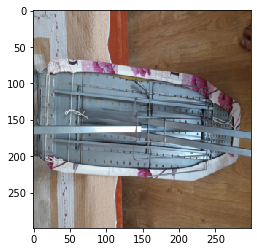

a pair of scissors and a knife on a table .
a pair of scissors and a knife on a table .
a pair of scissors on a table .
a pair of scissors sitting on a table .
a pair of scissors sitting on top of a wooden table .
a pair of scissors sitting on top of a table .
a small bird sitting on a wooden table .
a pair of scissors sitting on top of a wooden table .
a pair of scissors and a knife on a table .
a small white and black bird sitting on a table .
20160312_135802.jpg


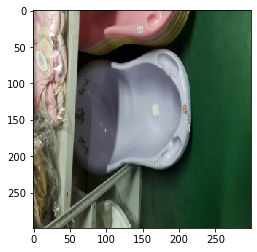

a close up of a bowl of food on a table .
a close up of a bowl of food in a bowl
a close up of a bowl of food on a table
a close up of a bowl of food on a table
a close up of a bowl of food on a table
a close up of a bowl of food on a table
a close up of a bowl of food on a table
a close up of a bowl of food on a table
a close up of a bowl of food .
a close up of a bowl of food on a table
20160313_133446.jpg


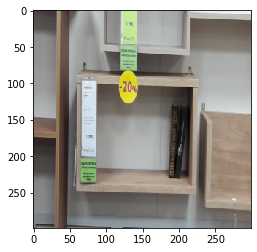

a small dog sitting on a wooden floor .
a small bathroom with a sink and a mirror
a small kitchen with a large window and a window .
a picture of a very old looking clock .
a small dog sitting in a kitchen with a stove .
a small dog sitting in a kitchen .
a small kitchen with a stove and a microwave .
a small white and black clock in a room .
a large mirror in a kitchen with a window .
a large mirror in a kitchen with a window .
20160313_145624.jpg


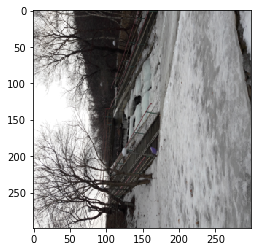

a stop sign sitting on the side of a road .
a stop sign with a snow covered in snow .
a stop sign with a snow covered in snow .
a stop sign on a pole near a street .
a stop sign sitting on the side of a road .
a stop sign with a snow covered in snow .
a white and black clock on a pole
a red and white fire hydrant in the middle of a street .
a stop sign in front of a building .
a stop sign on a pole next to a street .
professor.jpg


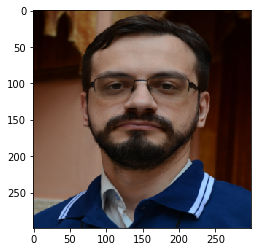

a man in a suit and tie holding a black and white tie .
a man wearing a tie and a tie .
a man wearing a tie and a tie .
a man wearing a tie and a tie .
a man in a suit and tie with a tie .
a man wearing a tie and a tie .
a man in a suit and tie with a tie .
a man wearing a tie and a tie .
a man wearing a tie and a tie .
a man wearing a suit and tie .


In [32]:
# apply your network on images you've found
#
#
import glob, os
imgs = '../content/drive/My Drive/kartinke'
for img in sorted(os.listdir(imgs)):
    print (img)
    photo = plt.imread(imgs + '/' + img)
    photo = imresize(photo, (299, 299)).astype('float32') / 255.
    plt.imshow(photo)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(photo, t=5.)[1:-1]))